In [27]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from sklearn.preprocessing import LabelEncoder, MinMaxScaler, OneHotEncoder
from sklearn.preprocessing import StandardScaler
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

from sklearn.metrics import roc_curve, auc, log_loss
from sklearn.metrics import classification_report, precision_recall_curve, auc
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score
from tqdm import tqdm

import torch 
import os
import torch

import warnings
warnings.filterwarnings("ignore")

In [28]:
is_cuda = torch.cuda.is_available()
device = torch.device('cuda' if is_cuda else 'cpu')
print(device)

cuda


In [29]:
## Load original data
data_path = "C:/Users/GCU/Lending_club/Data_Analysis_lending-club/VAE-CTGAN/dataset/train_category.csv"
data = pd.read_csv(data_path, low_memory=False)

##load test data
test_data_path = "C:/Users/GCU/Lending_club/Data_Analysis_lending-club/VAE-CTGAN/dataset/test_category.csv"
test_data = pd.read_csv(test_data_path)

In [38]:
data.columns

Index(['last_fico_range_high', 'annual_inc', 'dti', 'mo_sin_old_rev_tl_op',
       'revol_util', 'int_rate', 'installment', 'avg_cur_bal', 'revol_bal',
       'debt_settlement_flag', 'sub_grade', 'home_ownership', 'purpose',
       'grade', 'total_pymnt', 'total_pymnt_inv', 'funded_amnt', 'loan_amnt',
       'credit_history_years', 'term_months', 'loan_status'],
      dtype='object')

In [30]:
#keep_features = ['grade', 'term_months', 'total_pymnt', 'total_pymnt_inv','total_il_high_credit_limit', 'loan_amnt']
keep_features = ['grade', 'total_pymnt', 'total_pymnt_inv', 'loan_amnt','funded_amnt']

data_classification = data.copy()
test_classification = test_data.copy()

data_classification = data_classification.drop(columns = keep_features)
test_classification = test_classification.drop(columns = keep_features)

In [31]:
## data Encoding
Labelencoding_features = ['term_months', 'sub_grade']
onehot_features = ['debt_settlement_flag', 'home_ownership', 'purpose']

onehot_encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')

label_encoders = {}
for col in Labelencoding_features:
    le = LabelEncoder()
    data_classification[col] = le.fit_transform(data_classification[col])
    label_encoders[col] = le

# One-Hot Encoding
onehot_encoded = onehot_encoder.fit_transform(data_classification[onehot_features])
onehot_encoded_df = pd.DataFrame(
    onehot_encoded, 
    columns=onehot_encoder.get_feature_names_out(onehot_features),
    index=data_classification.index
)

# Merge
data_classification.drop(columns=onehot_features, inplace=True)
data_classification = pd.concat([data_classification, onehot_encoded_df], axis=1)

print("✅ Encoding 완료! 결과 shape:", data_classification.shape)

✅ Encoding 완료! 결과 shape: (1116458, 35)


In [32]:
##Test data encoding
for col in Labelencoding_features:
    le = label_encoders[col]
    test_classification[col] = le.transform(test_classification[col])

# One-Hot Encoding (train에서 fit된 onehot_encoder 재사용)
onehot_encoded_test = onehot_encoder.transform(test_classification[onehot_features])
onehot_encoded_test_df = pd.DataFrame(
    onehot_encoded_test,
    columns=onehot_encoder.get_feature_names_out(onehot_features),
    index=test_classification.index
)

# Merge
test_classification.drop(columns=onehot_features, inplace=True)
test_classification = pd.concat([test_classification, onehot_encoded_test_df], axis=1)

print("✅ 테스트 데이터 인코딩 완료! 결과 shape:", test_classification.shape)

✅ 테스트 데이터 인코딩 완료! 결과 shape: (744306, 35)


In [33]:
def encode_features(df, label_encoders, onehot_encoder, label_cols, onehot_cols):
    df = df.copy()
    
    # Label Encoding
    for col in label_cols:
        le = label_encoders[col]
        df[col] = le.transform(df[col])

    # One-Hot Encoding
    onehot_encoded = onehot_encoder.transform(df[onehot_cols])
    onehot_df = pd.DataFrame(
        onehot_encoded, 
        columns=onehot_encoder.get_feature_names_out(onehot_cols),
        index=df.index
    )

    df.drop(columns=onehot_cols, inplace=True)
    df = pd.concat([df, onehot_df], axis=1)
    
    return df

In [34]:
from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix

def return_evaluation(model, data_x, data_y, X_test, y_test, method):
    print(f"Preprocessing method : {method}")

    if method == 'Base':
        X_train, X_val, y_train, y_val = train_test_split(data_x, data_y, test_size=0.2,
                                                           random_state=42, stratify=data_y)
        model.fit(
        X_train, y_train,
        eval_set=[(X_train, y_train), (X_val, y_val)],  # Train & Validation Loss 저장
        verbose=True
        )

        y_prob = model.predict_proba(X_test)[:, 1]  # ROC Curve & PRC에 필요

        threshold = 0.5
        y_pred = (y_prob >= threshold).astype(int)


    elif method == 'Undersampling':
        X_train, X_val, y_train, y_val = train_test_split(data_x, data_y, test_size=0.13, random_state=42, stratify=data_y)
        undersampler = RandomUnderSampler(random_state=42)
        X_under, y_under = undersampler.fit_resample(X_train, y_train)

        data_under = pd.concat([pd.DataFrame(X_under, columns=data_x.columns), pd.DataFrame(y_under, columns=['loan_status'])], axis=1)
        X_train = data_under.drop(columns=['loan_status'])  # Feature (입력 데이터)
        y_train = data_under[['loan_status']]  # Target (타겟 변수)

        model.fit(
        X_train, y_train,
        eval_set=[(X_train, y_train), (X_val, y_val)],  # Train & Validation Loss 저장
        verbose=True
        )
        y_prob = model.predict_proba(X_test)[:, 1]  # ROC Curve & PRC에 필요

        threshold = 0.5
        y_pred = (y_prob >= threshold).astype(int)

    elif method == 'SMOTE-NC':
        smote_path = "C:/Users/GCU/Lending_club/Data_Analysis_lending-club/portfolios/smotenc/smotenc_data.csv"
        data_smote = pd.read_csv(smote_path)

        keep_features = ['grade', 'total_pymnt', 'total_pymnt_inv', 'loan_amnt','funded_amnt']
        data_smote_classification = data_smote.copy()
        data_smote_classification = data_smote_classification.drop(columns = keep_features)

        data_smote_classification = encode_features(data_smote_classification, label_encoders, onehot_encoder, Labelencoding_features, onehot_features)
        
        data_x = data_smote_classification.drop(columns='loan_status') 
        data_y = data_smote_classification[['loan_status']]

        X_train, X_val, y_train, y_val = train_test_split(data_x, data_y, test_size=0.2, random_state=42, stratify=data_y)

        model.fit(
            X_train, y_train,
            eval_set=[(X_train, y_train), (X_val, y_val)],  # Train & Validation Loss 저장
            verbose=True
        )
        y_prob = model.predict_proba(X_test)[:, 1]  # ROC Curve & PRC에 필요

        threshold = 0.5
        y_pred = (y_prob >= threshold).astype(int)
    
    elif method == 'table-gan':
        fake_path = "C:/Users/GCU/Lending_club/Data_Analysis_lending-club/portfolios/tablegan/tablegan.csv"
        fake = pd.read_csv(fake_path)
        fake['loan_status'] = 1
        
        keep_features = ['grade', 'total_pymnt', 'total_pymnt_inv', 'loan_amnt','funded_amnt']
        fake_Classification = fake.copy()
        fake_Classification = fake_Classification.drop(columns = keep_features)
        fake_Classification['term_months'] = fake_Classification['term_months'].apply(lambda x:36 if abs(x-36)<abs(x-60) else 60)
        fake_Classification = encode_features(fake_Classification, label_encoders, onehot_encoder, Labelencoding_features, onehot_features)

        X_train, X_val, y_train, y_val = train_test_split(data_x, data_y, test_size=0.2, random_state=42, stratify=data_y)
        train_dataset = pd.concat([X_train, y_train], axis=1)
        
        train_total = pd.concat([train_dataset,fake_Classification])
        train_total = shuffle(train_total, random_state=42)

        X_train = train_total.drop(columns='loan_status')
        y_train = train_total[['loan_status']]

        model.fit(
            X_train, y_train,
            eval_set=[(X_train, y_train), (X_val, y_val)],  # Train & Validation Loss 저장
            verbose=True
        )
        y_prob = model.predict_proba(X_test)[:, 1]  # ROC Curve & PRC에 필요

        threshold = 0.5
        y_pred = (y_prob >= threshold).astype(int)
        
    elif method == 'Smotified-tablegan':
        fake_path = "C:/Users/GCU/Lending_club/Data_Analysis_lending-club/portfolios/tablegan/smotified-tablegan.csv"
        fake = pd.read_csv(fake_path)
        fake['loan_status'] = 1

        keep_features = ['grade', 'total_pymnt', 'total_pymnt_inv', 'loan_amnt','funded_amnt']
        fake_Classification = fake.copy()
        fake_Classification = fake_Classification.drop(columns = keep_features)
        fake_Classification['term_months'] = fake_Classification['term_months'].apply(lambda x:36 if abs(x-36)<abs(x-60) else 60)
        fake_Classification = encode_features(fake_Classification, label_encoders, onehot_encoder, Labelencoding_features, onehot_features)
        
        X_train, X_val, y_train, y_val = train_test_split(data_x, data_y, test_size=0.2, stratify=data_y, random_state=42)
        train_dataset = pd.concat([X_train, y_train], axis=1)
        
        train_total = pd.concat([train_dataset,fake_Classification])
        train_total = shuffle(train_total)

        X_train = train_total.drop(columns='loan_status')
        y_train = train_total[['loan_status']]

        model.fit(
            X_train, y_train,
            eval_set=[(X_train, y_train), (X_val, y_val)],  # Train & Validation Loss 저장
            verbose=True
        )
        y_prob = model.predict_proba(X_test)[:, 1]  # ROC Curve & PRC에 필요

        threshold = 0.5
        y_pred = (y_prob >= threshold).astype(int)
    
    elif method == 'vae-tablegan':
        #Fake dataset
        fake_path = "C:/Users/GCU/Lending_club/Data_Analysis_lending-club/portfolios/tablegan/vae-tablegan.csv"
        fake = pd.read_csv(fake_path)
        fake['loan_status'] = 1

        keep_features = ['grade', 'total_pymnt', 'total_pymnt_inv', 'loan_amnt','funded_amnt']
        fake_Classification = fake.copy()
        fake_Classification = fake_Classification.drop(columns = keep_features)
        fake_Classification['term_months'] = fake_Classification['term_months'].apply(lambda x:36 if abs(x-36)<abs(x-60) else 60)
        fake_Classification = encode_features(fake_Classification, label_encoders, onehot_encoder, Labelencoding_features, onehot_features)
        
        X_train, X_val, y_train, y_val = train_test_split(data_x, data_y, test_size=0.2, stratify=data_y, random_state=42)
        train_dataset = pd.concat([X_train, y_train], axis=1)
        
        train_total = pd.concat([train_dataset,fake_Classification])
        train_total = shuffle(train_total)

        X_train = train_total.drop(columns='loan_status')
        y_train = train_total[['loan_status']]

        model.fit(
            X_train, y_train,
            eval_set=[(X_train, y_train), (X_val, y_val)],  # Train & Validation Loss 저장
            verbose=True
        )
        y_prob = model.predict_proba(X_test)[:, 1]  # ROC Curve & PRC에 필요

        threshold = 0.5
        y_pred = (y_prob >= threshold).astype(int)
    
    elif method == 'ctgan':
        #Fake dataset
        fake_path = "C:/Users/GCU/Lending_club/Data_Analysis_lending-club/portfolios/ctgan/ctgan.csv"
        fake = pd.read_csv(fake_path)
        fake['loan_status'] = 1

        keep_features = ['grade', 'total_pymnt', 'total_pymnt_inv', 'loan_amnt','funded_amnt']
        fake_Classification = fake.copy()
        fake_Classification = fake_Classification.drop(columns = keep_features)
        fake_Classification['term_months'] = fake_Classification['term_months'].apply(lambda x:36 if abs(x-36)<abs(x-60) else 60)
        fake_Classification = encode_features(fake_Classification, label_encoders, onehot_encoder, Labelencoding_features, onehot_features)
        
        X_train, X_val, y_train, y_val = train_test_split(data_x, data_y, test_size=0.2, stratify=data_y, random_state=42)
        train_dataset = pd.concat([X_train, y_train], axis=1)
        
        train_total = pd.concat([train_dataset,fake_Classification])
        train_total = shuffle(train_total)

        X_train = train_total.drop(columns='loan_status')
        y_train = train_total[['loan_status']]

        model.fit(
            X_train, y_train,
            eval_set=[(X_train, y_train), (X_val, y_val)],  # Train & Validation Loss 저장
            verbose=True
        )
        y_prob = model.predict_proba(X_test)[:, 1]  # ROC Curve & PRC에 필요

        threshold = 0.5
        y_pred = (y_prob >= threshold).astype(int)
    
    elif method == 'smotified-ctgan':
        #Fake dataset
        fake_path = "C:/Users/GCU/Lending_club/Data_Analysis_lending-club/portfolios/ctgan/smotified-ctgan.csv"
        fake = pd.read_csv(fake_path)
        fake['loan_status'] = 1

        keep_features = ['grade', 'total_pymnt', 'total_pymnt_inv', 'loan_amnt','funded_amnt']
        fake_Classification = fake.copy()
        fake_Classification = fake_Classification.drop(columns = keep_features)
        fake_Classification['term_months'] = fake_Classification['term_months'].apply(lambda x:36 if abs(x-36)<abs(x-60) else 60)
        fake_Classification = encode_features(fake_Classification, label_encoders, onehot_encoder, Labelencoding_features, onehot_features)
        
        X_train, X_val, y_train, y_val = train_test_split(data_x, data_y, test_size=0.2, stratify=data_y, random_state=42)
        train_dataset = pd.concat([X_train, y_train], axis=1)
        
        train_total = pd.concat([train_dataset,fake_Classification])
        train_total = shuffle(train_total)

        X_train = train_total.drop(columns='loan_status')
        y_train = train_total[['loan_status']]

        model.fit(
            X_train, y_train,
            eval_set=[(X_train, y_train), (X_val, y_val)],  # Train & Validation Loss 저장
            verbose=True
        )
        y_prob = model.predict_proba(X_test)[:, 1]  # ROC Curve & PRC에 필요

        threshold = 0.5
        y_pred = (y_prob >= threshold).astype(int)
    
    elif method == 'vae-ctgan':
        #Fake dataset
        fake_path = "C:/Users/GCU/Lending_club/Data_Analysis_lending-club/portfolios/ctgan/vae-ctgan.csv"
        fake = pd.read_csv(fake_path)
        fake['loan_status'] = 1

        keep_features = ['grade', 'total_pymnt', 'total_pymnt_inv', 'loan_amnt','funded_amnt']
        fake_Classification = fake.copy()
        fake_Classification = fake_Classification.drop(columns = keep_features)
        fake_Classification['term_months'] = fake_Classification['term_months'].apply(lambda x:36 if abs(x-36)<abs(x-60) else 60)
        fake_Classification = encode_features(fake_Classification, label_encoders, onehot_encoder, Labelencoding_features, onehot_features)
        
        X_train, X_val, y_train, y_val = train_test_split(data_x, data_y, test_size=0.2, stratify=data_y, random_state=42)
        train_dataset = pd.concat([X_train, y_train], axis=1)
        
        train_total = pd.concat([train_dataset,fake_Classification])
        train_total = shuffle(train_total)

        X_train = train_total.drop(columns='loan_status')
        y_train = train_total[['loan_status']]

        model.fit(
            X_train, y_train,
            eval_set=[(X_train, y_train), (X_val, y_val)],  # Train & Validation Loss 저장
            verbose=True
        )
        y_prob = model.predict_proba(X_test)[:, 1]  # ROC Curve & PRC에 필요

        threshold = 0.5
        y_pred = (y_prob >= threshold).astype(int)
        
    elif method == 'smotified-vae-ctgan':
        #Fake dataset
        fake_path = "C:/Users/GCU/Lending_club/Data_Analysis_lending-club/portfolios/ctgan/smotified-vae-ctgan.csv"
        fake = pd.read_csv(fake_path)
        fake['loan_status'] = 1

        keep_features = ['grade', 'total_pymnt', 'total_pymnt_inv', 'loan_amnt','funded_amnt']
        fake_Classification = fake.copy()
        fake_Classification = fake_Classification.drop(columns = keep_features)
        fake_Classification['term_months'] = fake_Classification['term_months'].apply(lambda x:36 if abs(x-36)<abs(x-60) else 60)
        fake_Classification = encode_features(fake_Classification, label_encoders, onehot_encoder, Labelencoding_features, onehot_features)
        
        X_train, X_val, y_train, y_val = train_test_split(data_x, data_y, test_size=0.2, stratify=data_y, random_state=42)
        train_dataset = pd.concat([X_train, y_train], axis=1)
        
        train_total = pd.concat([train_dataset,fake_Classification])
        train_total = shuffle(train_total)

        X_train = train_total.drop(columns='loan_status')
        y_train = train_total[['loan_status']]

        model.fit(
            X_train, y_train,
            eval_set=[(X_train, y_train), (X_val, y_val)],  # Train & Validation Loss 저장
            verbose=True
        )
        y_prob = model.predict_proba(X_test)[:, 1]  # ROC Curve & PRC에 필요

        threshold = 0.5
        y_pred = (y_prob >= threshold).astype(int)
    
    elif method == 'ctab-gan':
        #Fake dataset
        fake_path = "C:/Users/GCU/Lending_club/Data_Analysis_lending-club/portfolios/ctabgan/ctabgan.csv"
        fake = pd.read_csv(fake_path)
        fake['loan_status'] = 1

        keep_features = ['grade', 'total_pymnt', 'total_pymnt_inv', 'loan_amnt','funded_amnt']
        fake_Classification = fake.copy()
        fake_Classification = fake_Classification.drop(columns = keep_features)
        fake_Classification['term_months'] = fake_Classification['term_months'].apply(lambda x:36 if abs(x-36)<abs(x-60) else 60)
        fake_Classification = encode_features(fake_Classification, label_encoders, onehot_encoder, Labelencoding_features, onehot_features)
        
        X_train, X_val, y_train, y_val = train_test_split(data_x, data_y, test_size=0.2, stratify=data_y, random_state=42)
        train_dataset = pd.concat([X_train, y_train], axis=1)
        
        train_total = pd.concat([train_dataset,fake_Classification])
        train_total = shuffle(train_total)

        X_train = train_total.drop(columns='loan_status')
        y_train = train_total[['loan_status']]

        model.fit(
            X_train, y_train,
            eval_set=[(X_train, y_train), (X_val, y_val)],  # Train & Validation Loss 저장
            verbose=True
        )
        y_prob = model.predict_proba(X_test)[:, 1]  # ROC Curve & PRC에 필요

        threshold = 0.5
        y_pred = (y_prob >= threshold).astype(int)
    
    ##confusion matrix 만들기
    cm = confusion_matrix(y_test, y_pred)

    tn, fp, fn, tp = cm.ravel()
    total = tn + fp + fn + tp

    cm_dict = {
        "Method": method,
        "TN": tn / total,
        "FP": fp / total,
        "FN": fn / total,
        "TP": tp / total,
        "Total": total
    }

    confusion_results.append(cm_dict)

In [35]:
Methods = ['Base', 'Undersampling', 'SMOTE-NC', 'table-gan','Smotified-tablegan','vae-tablegan','ctgan','smotified-ctgan','vae-ctgan','smotified-vae-ctgan','ctab-gan']

X_test = test_classification.drop(columns='loan_status')
y_test = test_classification['loan_status']

returns_df = pd.DataFrame()

confusion_results = []

for method in Methods:
    data_x = data_classification.drop(columns='loan_status')
    data_y = data_classification['loan_status']

    model = XGBClassifier(
        n_estimators=500,
        learning_rate=0.01,
        objective='binary:logistic',
        eval_metric="logloss",
        random_state=42,
        verbosity=0
    )

    return_evaluation(model, data_x, data_y, X_test, y_test, method)


Preprocessing method : Base
[0]	validation_0-logloss:0.49145	validation_1-logloss:0.49146
[1]	validation_0-logloss:0.48638	validation_1-logloss:0.48640
[2]	validation_0-logloss:0.48145	validation_1-logloss:0.48148
[3]	validation_0-logloss:0.47666	validation_1-logloss:0.47670
[4]	validation_0-logloss:0.47200	validation_1-logloss:0.47205
[5]	validation_0-logloss:0.46747	validation_1-logloss:0.46753
[6]	validation_0-logloss:0.46306	validation_1-logloss:0.46312
[7]	validation_0-logloss:0.45876	validation_1-logloss:0.45883
[8]	validation_0-logloss:0.45456	validation_1-logloss:0.45465
[9]	validation_0-logloss:0.45047	validation_1-logloss:0.45057
[10]	validation_0-logloss:0.44649	validation_1-logloss:0.44659
[11]	validation_0-logloss:0.44259	validation_1-logloss:0.44271
[12]	validation_0-logloss:0.43879	validation_1-logloss:0.43892
[13]	validation_0-logloss:0.43508	validation_1-logloss:0.43521
[14]	validation_0-logloss:0.43145	validation_1-logloss:0.43159
[15]	validation_0-logloss:0.42790	val

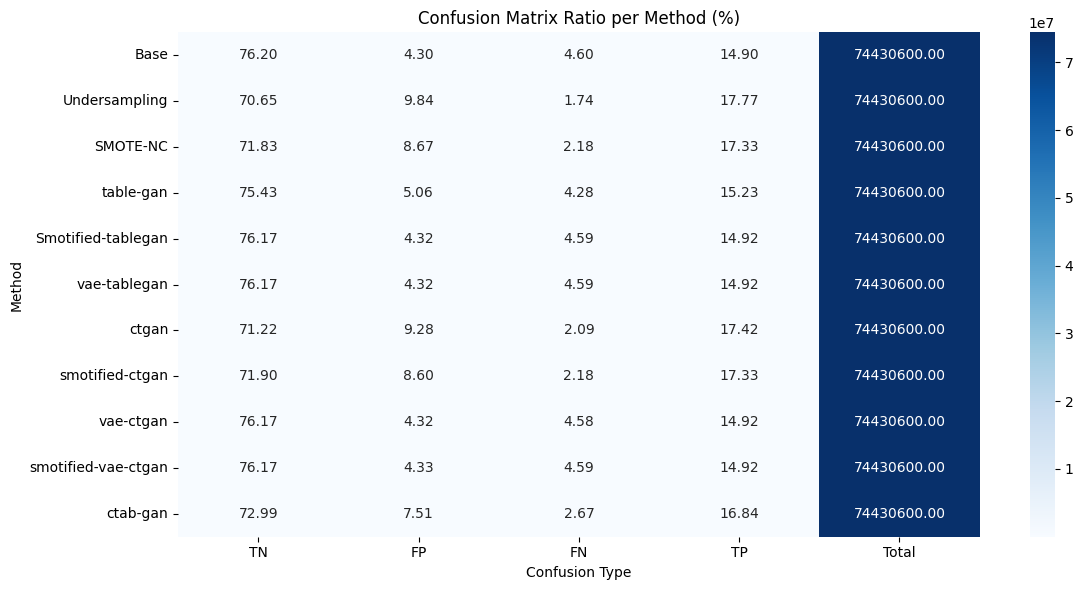

In [36]:
### confusion_matrix 만들기

confusion_df = pd.DataFrame(confusion_results)
confusion_df = confusion_df.set_index("Method")
confusion_df = (confusion_df * 100).round(2)  # 퍼센트(%) 단위로 보기 좋게

import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
sns.heatmap(confusion_df, annot=True, cmap="Blues", fmt=".2f")
plt.title("Confusion Matrix Ratio per Method (%)")
plt.ylabel("Method")
plt.xlabel("Confusion Type")
plt.tight_layout()
plt.show()

In [37]:
confusion_df

,TN,FP,FN,TP,Total
Method,,,,,
Base,76.20,4.30,4.60,14.90,74430600
Undersampling,70.65,9.84,1.74,17.77,74430600
SMOTE-NC,71.83,8.67,2.18,17.33,74430600
table-gan,75.43,5.06,4.28,15.23,74430600
Smotified-tablegan,76.17,4.32,4.59,14.92,74430600
vae-tablegan,76.17,4.32,4.59,14.92,74430600
ctgan,71.22,9.28,2.09,17.42,74430600
smotified-ctgan,71.90,8.60,2.18,17.33,74430600
vae-ctgan,76.17,4.32,4.58,14.92,74430600
